# Le modèle de Mitchell-Schaeffer
## Présentation du modèle
C'est le système de deux équations différentielles
$$v'(t) = h\frac{v^2(1-v)}{\tau_{in}} - \frac{v}{\tau_{out}} + s(t),$$
$$h'(t) = \frac{h_\infty(v)-h}{\tau(v)}$$
où $v$ représente le voltage de la membrane cellulaire et $h$ est une variable d'état. On prend $h_\infty(v) = 1$ si $v<v_{gate}$ et $0$ sinon, et $\tau(v) = \tau_{open}$ si $v<v_{gate}$ et $\tau_{close}$ sinon.

Les paramètres suggérés dans l'article qui présente ce modèle sont:
 - $\tau_{in} = 0.3$ ms
 - $\tau_{out} = 6$ ms
 - $\tau_{open} = 120$ ms
 - $\tau_{close} = 150$ ms
 - $v_{gate} = 0.13$
La valeur du voltage $v$ varie entre $0$ et $1$. Elle est donc adimensionné, à la différence du temps, qui est mesuré en ms.

Ce modèle est programmé dans le module [ms.py](./ms.py). Les membres de ce modules sont: 
 - les paramètres du modèles listés ci-dessus
 - les paramètre du terme de stimulation $s(t)$,
   + le décalage en temps du premier stimulus (stim.offset=10 ms par défaut)
   + la durée d'un stimulus (stim.duration = 1 ms par défaut)
   + la période (stim.period = 600 ms par défaut)
   + l'amplitude (stim.amplitude = 0.1 par défaut)
 - la fonction de stimulation $s(t)$
 - la fonction $f(t,y)$ telle que le modèles s'écrit $y'(t) = f(t,y(t))$ avec $y(t) = (v(t), h(t))$
 - la méthode solve(t,y0) qui renvoie la solution approchée aux instants t pour une donnée initiale y0.

On peut simplement tracer une solution avec les paramètres par défaut pour voir...

D'abord on charge l'environnement de travail, numpy, matplotlib et notre module ms.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import ms
import stimulation as stim

On peut maintenant tracer une solution, sans toucher aux paramètres par défaut du module.

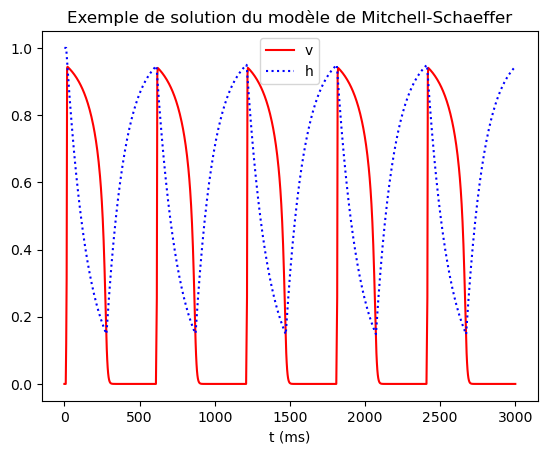

In [8]:
t = np.linspace(0.,3000.,1001)
y = ms.solve(t,y0=[0.,1.]) # v=0 et h=1 est l'état d'équilibre du système
plt.plot(t,y[:,0], 'r-', label='v')
plt.plot(t,y[:,1], 'b:', label='h')
plt.xlabel('t (ms)')
plt.legend()
plt.title('Exemple de solution du modèle de Mitchell-Schaeffer')
plt.show()

Le module ms expose aussi une méthode "plot-solution" qui fait ce tracé, avec comme arguments les paramètres du modèle, la fréquence (en BPM) et le temps total souhaité.

## Travail: étude paramétrique
1. Que se passe-t-il si l'on augmente la fréquence de stimulation ? 
2. Déterminer expérimentalement la fréqence à laquelle le modèle ne répond qu'une fois sur 2.
3. On définit ici la durée du potentiel d'action comme la différence $APD = t_2-t_1$ entre les temps $t_1$ et $t_2$ définis par $u(t)=0.2$, et $u'(t)>0$ pour $t_1$, $u'(t)<0$ pour $t_2$. Tracer la courbe de réponse donnant l'APD (le dernier d'une série de 4 ou 5) en fonction de la période de stimulation.
4. En complément (voir plus bas), on peut étudier le modèle de manière interactive, et observer que son comportement peut être très complexe, pour certains jeux de paramètres.

In [ ]:
# Faire le travail demandé ici...

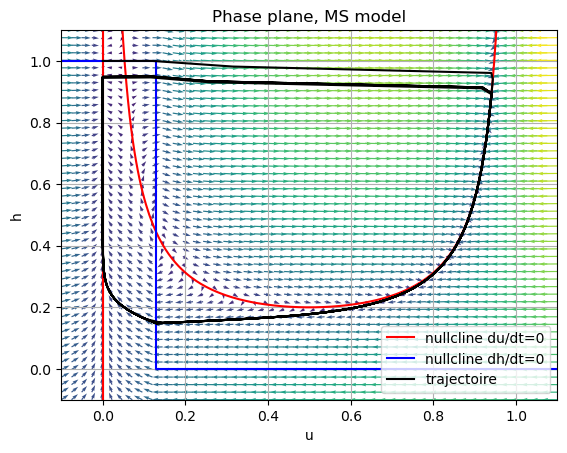

In [9]:
fig,ax = plt.subplots()
ms.plot_phase_plane(ax)
ax.plot(y[:,0],y[:,1],'k',label='trajectoire')
ax.legend(loc="lower right")

## Complément
On peut étudier de manière interactive ce modèle, en chargeant le module ipywidgets, voir https://ipywidgets.readthedocs.io/en/stable/

In [10]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Maintenant, on définit une fonction qui trace le graphe souhaité, avec comme argument les parametres que l'on souhaite étudier.

In [5]:
def plot_solution(tau_in=0.3, tau_out=6.0, tau_open=120.0,
                  tau_close=150.0, v_gate=0.13, BPM=70., t_final=2500.):
    """Plot the solution of the MS model on a fixed period of time, as a
    function of the parameters of the MS model. To be used in a Notebook
    with ipywidgets, in order to experiment the model's properties.

    """
    ms.tau_in, ms.tau_out, ms.tau_open, ms.tau_close, ms.v_gate = tau_in, tau_out, tau_open, tau_close, v_gate
    ms.stim.period = 60.e3/BPM # Period in ms

    t0,t1 = 0., t_final
    t = np.linspace(t0,t1,np.int32(t1-t0)+1)
    y0 = np.array([0.,1.0]) # Start form the steady state
   
    y = ms.solve(t,y0)

    # Built the stimulation times. The time of activation are the time t
    # = offset + k*period that are less than t1. Hence the maxium value
    # of k is (t1-offset)/period.
    Ns = np.floor_divide(t1-ms.stim.offset, ms.stim_period)
    t_stim = ms.stim_offset + np.arange(Ns+1)*ms.stim_period
    y_stim = 0.*t_stim
    
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,12))
    
    #plt.figure(figsize=(12,6)) # Large cell to better show more AP
    ax1.plot(t,y[:,0], 'r-', label='u')
    ax1.plot(t,y[:,1], 'b:', label='h')
    ax1.plot(t_stim,y_stim, 'k+', label='stimulation')
    ax1.set_title('Phase plane, MS model')
    ax1.set_xlabel('t (ms)')
    ax1.set_ylabel('u,h')
    ax1.legend(loc="upper right")
    ax1.set_title('MS model stimulated at at {} BPM'.format(BPM))
    
    ms.plot_phase_plane(ax2)
    ax2.plot(y[:,0],y[:,1],'k',label='trajectoire')
    ax2.legend(loc="lower right")

Et il suffit d'appeler la fonction interact comme ci-dessous.

In [6]:
interact(plot_solution, 
         tau_in=widgets.FloatSlider(min=0.1,max=1,step=0.05,value=0.3),
         tau_out=widgets.FloatSlider(min=1,max=10,step=0.5,value=6.0),
         tau_open=widgets.FloatSlider(min=20,max=400,step=20,value=120.0),
         tau_close=widgets.FloatSlider(min=20,max=400,step=20,value=150.0),
         v_gate=fixed(0.13),
         BPM=widgets.IntSlider(min=10,max=500,step=5,value=70),
         t_final=widgets.FloatSlider(min=0,max=10000,step=50,value=5000));

interactive(children=(FloatSlider(value=0.3, description='tau_in', max=1.0, min=0.1, step=0.05), FloatSlider(v…